In [49]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

In [50]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from interval import interval, inf, imath

In [51]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

In [52]:
def xy2q(t, x, y, i, ω, Ω) :   # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω), np.sin(Ω)] # longitude of the ascending node converted to its cosine and sine
    ν = np.sin(i)              # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600  # time (s) converted to orbital plane normal-vector azimuth (radian)
                               # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν, np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
                               # ν converted to unit normal vector of orbital plane
    λ = np.cross([0, 0, 1], ν) # vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,axis=1)**-.5)@λ
                               # normalize λ
    μ = np.cross(ν, λ)         # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


In [53]:
def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    # Insert interval on the end of area_covered
    # print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    # Insert interval on the end of area_covered
    # print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

In [8]:
def swath_coverage(theta, h):
    swath = (2 * h * np.tan( (np.pi / 180) / 2 * (theta) )) / 1000
    return swath

In [54]:
day = 16                     # roughly 16 orbits in one day -- exactly for a period of 1.5 hours
num_days = (.5)              # number of days we want to simulate
orbits = (num_days)*day      # number of orbits we will simulate
satellites = 3               # number of satellites we wish to simulate -- << 13
h = 400                      # altitude in kilometers
swath = swath_coverage(30,h) # swath based on calculation of altitude 
s = swath/2                  # half the length
inclination = 1.449          # np.sin takes radians ==> 83° × π/180 = 1.449rad
e = .1                       # eccentricity
G = 6.67430e-11              # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]         # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 250                      # nu. plot points
R = 6371.0088e3              # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)                 # gravitational parameter, eq. 1, m³/s²
a = (R + h*1000)/(1 - e)     # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)              # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5          # eq. 15, semi-minor axis
H = (α*p)**.5                # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5     # eq. 43, orbital period for an elliptic orbit, s

# Defined later
#t = np.linspace(0,.99*P, N) # time list, s
#E = t2E(e, H*t/a/b)         # eq. 25, eccentric anomaly list, radians
#x = a*(np.cos(E) - e)       # eq. 20, x-coordinate list
#y = b*np.sin(E)             # eq. 21, y-coordinate list

In [55]:
# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []
slope = []

In [56]:
# Setting up parameters in order to center a point on an interpolated line at the equator
#       and to calculate the length of the swath crossing the equator, given our angle of  
#                                                                             inclination
u1 = []
v1 = []
a1 = []
b1 = []
h  = []
swath_length = []

In [57]:
# Setting up parameters to track the coverage as we pass the equator
equator_catch_plus  = []
equator_catch_minus = []
interval_caught1    = []
interval_caught2    = []

In [58]:
t = np.linspace(0, orbits*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)               # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)             # eq. 20, x-coordinate list
y = b*np.sin(E)                   # eq. 21, y-coordinate list

vals = np.linspace(1,12,satellites)
for i in range(0,satellites):
    vals[i] = np.floor(vals[i])
q = [0]*satellites                # empty array of size # of satellite
for i in range(0,satellites):     # get x,y,z - coords. for each satellite desired
    ω = 0
#    Ω = np.pi/4
    Ω = np.pi/vals[i]
    q[i] = xy2q(t, x, y, inclination, ω, Ω)

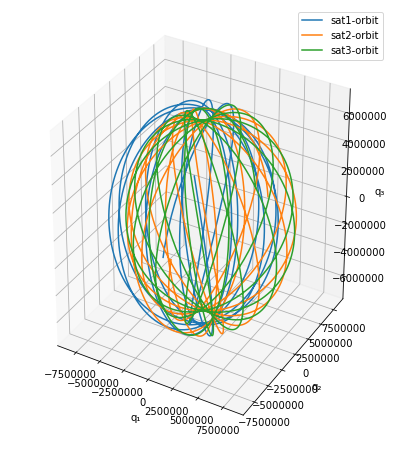

In [59]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,2,1,projection='3d')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(q[i][:,0], q[i][:,1], q[i][:,2], label=title)
#    ax.plot(q[i][:,0] / 1000, q[i][:,1] / 1000, q[i][:,2] / 1000, label=title) # Change the scale to km?
ax.set_xlabel('q₁')
ax.set_ylabel('q₂')
ax.set_zlabel('q₃')
ax.legend()

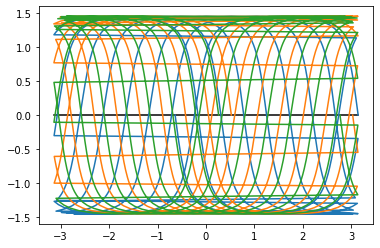

In [60]:
# convert for ground-tracking
psi = [0]*satellites
phi = [0]*satellites

for i in range(0,satellites):
    psi[i] = np.arctan2(q[i][:,0], q[i][:,1]) 
    qq = np.zeros(np.size(q[i][:,2]))
    for j in range(0,np.size(q[i][:,2])):
        qq[j] = q[i][j,2] / np.sqrt( q[i][j,0]**2 + q[i][j,1]**2 + q[i][j,2]**2 )
    phi[i] = np.arcsin( qq )

plt.plot([-np.pi,np.pi],[0,0],c='k') # equitorial line
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])

In [61]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line

for i in range(0,satellites):
    for j in range(0,np.size(phi[i])-1):
        if( phi[i][j] > 0 and phi[i][j+1] < 0 ):
            x1.append( psi[i][j] )            # x1
            x2.append( psi[i][j+1] )          # x2
            y1.append( phi[i][j] )            # y1
            y2.append( phi[i][j+1] )          # y2
        else:
            if( phi[i][j] < 0 and phi[i][j+1] > 0 ):
                x1.append( psi[i][j] )            # x1
                x2.append( psi[i][j+1] )          # x2
                y1.append( phi[i][j] )            # y1
                y2.append( phi[i][j+1] )          # y2

In [62]:
# Calculating slope of the line crossing the equator.
n = np.size(x1)
for i in range(0,n):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


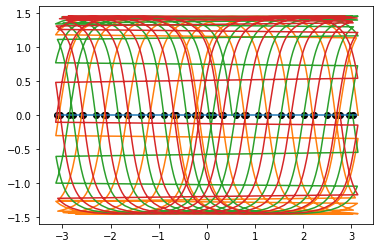

In [63]:
# centering a point at the equitorial line (a1,b1) each time we cross

for i in range(0,n):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,n):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )        

colors = (0,0,0)
plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(a1,b1,c=colors)
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])
plt.show()

In [64]:
# Using what Greg thinks should work

for i in range(0,n):
    h.append( s / (np.cos( np.arctan( slope[i] ) )) )

for i in range(0,n):
    swath_length.append( h[i] / slope[i] )

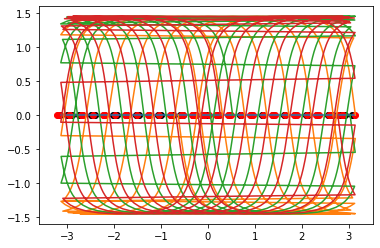

In [65]:
for i in range(0,n):
    equator_catch_plus.append( a1[i] + swath_length[i] )
    equator_catch_minus.append( a1[i] - swath_length[i] )
#print(equator_catch_plus,'\n')
#print(equator_catch_minus)

plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(equator_catch_plus,b1,c='k')
plt.scatter(equator_catch_minus,b1,c='r')
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])

In [66]:
# Comparing each interval we've crossed through periods and combining 
#     overlapping intervals. As well as offsetting the interval we've 
#         caught so instead of looking at [-pi,pi] we look at [0,2pi]
#       this should be easier to convert to a scale needed to compare
#                           with the equitorial coverage of the Earth
m = np.size(equator_catch_plus)
for i in range(0,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
for i in range(1,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(np.size(interval_caught2,0),interval_caught2)
print('\n')

m1 = np.size(interval_caught1,0)
m2 = np.size(interval_caught2,0)
area_passed_over_eq1 = interval_caught1[0]
area_passed_over_eq2 = interval_caught2[0]

for i in range(1,m1):
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )

for i in range(1,m2):
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )
    
print(np.size(area_passed_over_eq1,0),area_passed_over_eq1)
print('\n')
print(np.size(area_passed_over_eq2,0),area_passed_over_eq2)

24 [[2.7958387200215493, 3.0150743538349856], [2.3235663827208697, 2.542802286000194], [1.8512940026347084, 2.0705304449786306], [1.3790216432031002, 1.5982588942487828], [0.9067498350343821, 1.1259870861931103], [0.43447828825033996, 0.6537147307027085], [-0.037793553524251955, 0.18144234970104822], [5.773119685659779, 5.99235531947318], [0.1778448420300549, 0.3970804758434916], [5.988757811908961, 6.207993715188286], [5.516485431822801, 5.735721874166723], [5.044213072391193, 5.263450323436874], [4.571941264222474, 4.791178515381203], [4.099669717438432, 4.3189061598908], [3.6273978756638403, 3.8466337788891405], [3.155125807668284, 3.374361441481686], [-0.08395454576909467, 0.13528108804434202], [5.726958424109812, 5.9461943273891364], [5.254686044023652, 5.473922486367574], [4.7824136845920435, 5.001650935637725], [4.310141876423325, 4.529379127582053], [3.8378703296392827, 4.057106772091651], [3.365598487864691, 3.584834391089991], [2.893326419869135, 3.1125620536825367]] 

24 [[5

In [67]:
# Post processing:
# We have a case where we go beyond the [0,2pi] range.
# This cell is fixing the left endpoint

# Setting tolerance in which we want to consider
#         the distance traveled beyond or domain
tol = -1e-10

# This checks the boolean of how negative the left end-point is
boo = tol in interval(area_passed_over_eq1[0])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    print('\n')
    area_passed_over_eq1 = coverage_correction_left(area_passed_over_eq1)
    print(area_passed_over_eq1)

print('\n')
boo = tol in interval(area_passed_over_eq2[0])
if( boo == True ):
    print('2\n')
    print(area_passed_over_eq2)
    print('\n')
    area_passed_over_eq2 = coverage_correction_left(area_passed_over_eq2)    
    print(area_passed_over_eq2)

1

interval([-0.08395454576909467, 0.3970804758434916], [0.43447828825033996, 0.6537147307027085], [0.9067498350343821, 1.1259870861931103], [1.3790216432031002, 1.5982588942487828], [1.8512940026347084, 2.0705304449786306], [2.3235663827208697, 2.542802286000194], [2.7958387200215493, 3.1125620536825367], [3.155125807668284, 3.584834391089991], [3.6273978756638403, 4.057106772091651], [4.099669717438432, 4.529379127582053], [4.571941264222474, 5.001650935637725], [5.044213072391193, 5.473922486367574], [5.516485431822801, 6.207993715188286])


interval([0.0, 0.3970804758434916], [0.43447828825033996, 0.6537147307027085], [0.9067498350343821, 1.1259870861931103], [1.3790216432031002, 1.5982588942487828], [1.8512940026347084, 2.0705304449786306], [2.3235663827208697, 2.542802286000194], [2.7958387200215493, 3.1125620536825367], [3.155125807668284, 3.584834391089991], [3.6273978756638403, 4.057106772091651], [4.099669717438432, 4.529379127582053], [4.571941264222474, 5.001650935637725], 

In [68]:
# Now to fix the right endpoint if we go past 2*pi

# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
tol = 1e-10

# This checks the boolean of how negative the left end-point is
boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])

if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    area_passed_over_eq1 = coverage_correction_right(area_passed_over_eq1)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq2)
    area_passed_over_eq2 = coverage_correction_right(area_passed_over_eq2)
    print('\n')
    print(area_passed_over_eq2)

In [69]:
# Now we convert this output in relation to the circumference of Earth -- 40,075 km
area_passed_over_eq1 = area_passed_over_eq1 * (R/1000) # convert to distance traveled in km
area_passed_over_eq2 = area_passed_over_eq2 * (R/1000) # convert to distance traveled in km
print('1 ',area_passed_over_eq1,'\n')
print('2 ',area_passed_over_eq2)

1  interval([0.0, 2529.8032059070724], [2768.0649978518522, 4164.822301996586], [5776.911178402596, 7173.673634822664], [8785.75902423741, 10182.521479937264], [11794.610382172948, 13191.367685626772], [14803.461871698826, 16200.215740767355], [17812.313088638024, 19830.160234557516], [20101.334285761743, 22839.011452176976], [23110.18378695563, 25847.862947535505], [26119.03184689376, 28856.714280361582], [29127.8780274445, 31865.562125476183], [32136.725873279323, 34874.408331165694], [35145.57723121486, 40030.22888407185]) 

2  interval([0.0, 1315.4138949166465], [1594.6898130252464, 4324.257961151625], [4603.543308119403, 7333.106908894047], [7612.397908013243, 10341.959212938487], [10621.252099803978, 13350.813388450735], [13630.104389404954, 21036.447678634668], [21282.805343149335, 22671.446199684553], [24291.659943043178, 25680.295147426972], [27300.514134833913, 28689.14745147142], [30309.366424434887, 31698.00162698366], [33318.21536050413, 34706.85621745328], [36327.05942832

<Figure size 432x288 with 0 Axes>

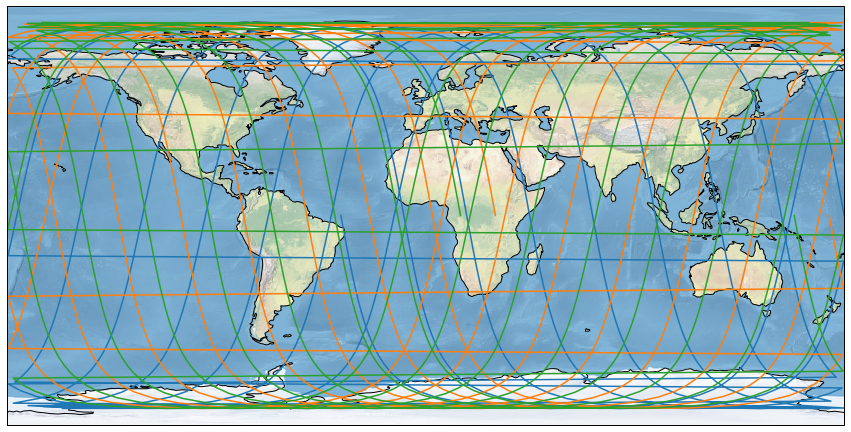

In [70]:
fig = plt.figure()
src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
for i in range(0,satellites):
    lon = psi[i] # [-pi,pi]
    lat = phi[i] # [-pi/2,pi/2]
    # converting to degrees
    lon = lon * (180/np.pi)
    lat = lat * (180/np.pi)
    ax.plot(lon,lat)